2025-07-30 16:38:26.552793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 16:38:26.564228: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 16:38:26.641565: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 16:38:26.697525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753861106.755168     521 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753861106.77

Performing Singular Spectrum Analysis...


Applying SSA:   0%|          | 0/6 [00:00<?, ?it/s]

Train set size: 1059475
Validation set size: 302707
Test set size: 151354

Training SSA-CNN-LSTM model...


/home/steve/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1753861124.979505     521 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753861124.980261     521 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - loss: 4.9984e-04 - val_loss: 7.1198e-05
Epoch 2/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - loss: 1.9419e-04 - val_loss: 6.0110e-06
Epoch 3/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.9041e-04 - val_loss: 2.0937e-05
Epoch 4/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.8803e-04 - val_loss: 2.5568e-06
Epoch 5/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.8667e-04 - val_loss: 3.9896e-05
Epoch 6/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.8574e-04 - val_loss: 3.5096e-05
Epoch 7/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.8462e-04 - val_loss: 5.8977e-06
Epoch 8/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 1.8320e-04 - val_loss: 8.8246e-05
Epoch 9/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - loss: 1.8356e-04 - val_loss: 3.8059e-06
Epoch 10/1000
4139/4139 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.8341e-04 - val_loss: 1.8828e-05

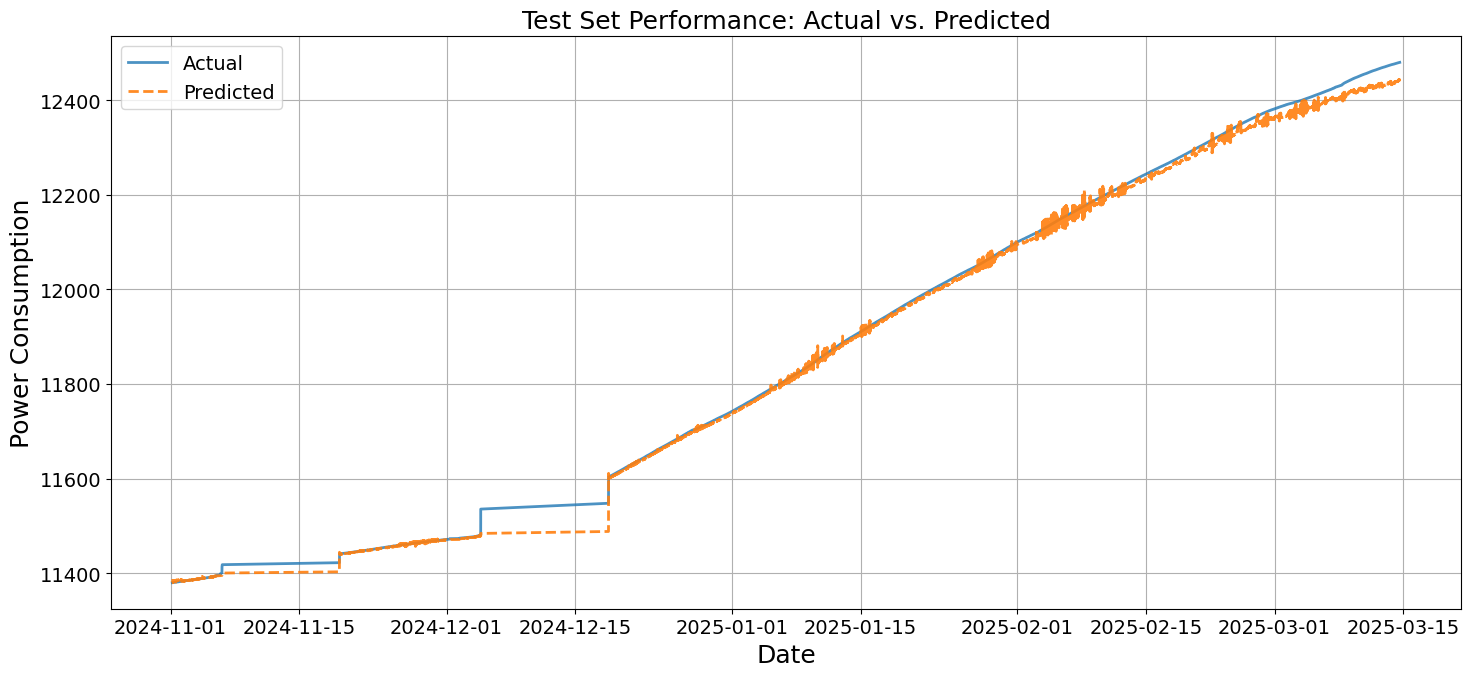

In [1]:
# %%
# SSA-CNN-LSTM 모델 (Train:Valid:Test = 7:2:1 분할)

import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm

# %% 설정
WINDOW_SIZE = 60
BATCH_SIZE = 256
EPOCHS = 1000
PATIENCE = 20
LR = 0.004

# %% 데이터 로드 및 전처리
df = pd.read_csv("/home/steve/urop-solar/20250317.csv")
df = df.dropna()
df['REG_DATE'] = pd.to_datetime(df['REG_DATE'])
df = df.set_index('REG_DATE').sort_index()

target = df['pwr_cnsmp']
additional = df[['abso_humid','rain','wind_velo','temp_outside','solar_radiation_outside']]
df_feat = pd.concat([target, additional], axis=1)

# %% [A] SSA 파이프라인
print("Performing Singular Spectrum Analysis...")
ssa = SingularSpectrumAnalysis(window_size=10)
ssa_comps = []
for col in tqdm(df_feat.columns, desc="Applying SSA"):
    arr = df_feat[col].values.reshape(1, -1)
    comp = ssa.fit_transform(arr)[0,0,:]
    ssa_comps.append(comp)

ssa_main = np.array(ssa_comps).T
scaler_ssa = MinMaxScaler()
ssa_scaled = scaler_ssa.fit_transform(ssa_main)

# %% 시퀀스 생성
def create_sequences(data, ws):
    X, y = [], []
    for i in range(len(data) - ws):
        X.append(data[i:i+ws])
        y.append(data[i+ws, 0])
    return np.array(X), np.array(y)

X_ssa, y_ssa = create_sequences(ssa_scaled, WINDOW_SIZE)

# %% Train/Validation/Test 분할 (7:2:1 비율)
train_split_idx = int(len(X_ssa) * 0.7)
valid_split_idx = int(len(X_ssa) * 0.9) # 70% + 20% = 90%

# 훈련셋 (70%)
X_train, y_train = X_ssa[:train_split_idx], y_ssa[:train_split_idx]
# 검증셋 (20%)
X_val, y_val = X_ssa[train_split_idx:valid_split_idx], y_ssa[train_split_idx:valid_split_idx]
# 테스트셋 (10%)
X_test, y_test = X_ssa[valid_split_idx:], y_ssa[valid_split_idx:]

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# %% 모델 학습
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(WINDOW_SIZE, X_ssa.shape[2])),
    MaxPooling1D(2),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer=Adam(LR), loss='mse')

print("\nTraining SSA-CNN-LSTM model...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[es], verbose=1)

# %% 테스트 데이터에 대한 예측 및 평가
print("\nPredicting on the test set...")
y_pred_scaled = model.predict(X_test).flatten()

# 스케일링 역변환 함수
def inv_first(scaler, arr):
    n = arr.shape[0]
    dummy = np.zeros((n, scaler.scale_.shape[0]))
    dummy[:,0] = arr
    return scaler.inverse_transform(dummy)[:,0]

# 예측값과 실제값 모두 원래 스케일로 복원
y_pred_unscaled = inv_first(scaler_ssa, y_pred_scaled)
y_test_unscaled = inv_first(scaler_ssa, y_test)

# 성능 지표 계산
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)

print("\n--- Test Set Performance ---")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("--------------------------")

# %% 플롯 데이터 준비
idx_full = df_feat.index[WINDOW_SIZE:]
idx_test = idx_full[valid_split_idx:]

# %% 플롯 (Test Set: Actual vs Predicted)
plt.figure(figsize=(15, 7))
plt.rcParams.update({'font.size': 14})

plt.plot(idx_test, y_test_unscaled, label='Actual', linewidth=2, alpha=0.8)
plt.plot(idx_test, y_pred_unscaled, label='Predicted', linewidth=2, linestyle='--', alpha=0.9)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Power Consumption', fontsize=18)
plt.title('Test Set Performance: Actual vs. Predicted', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# %%
# SSA-CNN-LSTM 모델 (시계열 교차검증 적용)

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# %% 하이퍼파라미터 (R²=0.80 모델 기준으로 복원)
WINDOW_SIZE = 60
BATCH_SIZE = 2048
EPOCHS = 1000
PATIENCE = 20
LR = 0.003

# %% 데이터 로드 및 전처리
df = pd.read_csv("/home/steve/urop-solar/20250317.csv")
df = df.dropna()
df['REG_DATE'] = pd.to_datetime(df['REG_DATE'])
df = df.set_index('REG_DATE').sort_index()

target = df['pwr_cnsmp']
additional = df[['abso_humid','rain','wind_velo','temp_outside','solar_radiation_outside']]
df_feat = pd.concat([target, additional], axis=1)

# %% SSA 파이프라인 (R²=0.80 모델 기준으로 복원: 첫 번째 성분만 사용)
print("Performing Singular Spectrum Analysis...")
ssa = SingularSpectrumAnalysis(window_size=10)
ssa_comps = []
for col in tqdm(df_feat.columns, desc="Applying SSA"):
    arr = df_feat[col].values.reshape(1, -1)
    comp = ssa.fit_transform(arr)[0,0,:]
    ssa_comps.append(comp)

ssa_main = np.array(ssa_comps).T

# %% 시퀀스 생성 (전체 데이터 대상)
def create_sequences(data_X, data_y, ws):
    X, y = [], []
    for i in range(len(data_X) - ws):
        X.append(data_X[i:i+ws])
        y.append(data_y[i+ws])
    return np.array(X), np.array(y)

X_full, y_full = create_sequences(ssa_main, ssa_main[:, 0], WINDOW_SIZE)

# %% 시계열 교차검증 루프
n_splits = 5 # Fold 수 설정 (데이터 크기에 따라 조절)
tscv = TimeSeriesSplit(n_splits=n_splits)

scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_full)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    
    # 1. 데이터 분할
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train_orig, y_test_orig = y_full[train_index], y_full[test_index]
    
    # 2. 스케일링 (매 Fold마다 훈련 데이터 기준으로 새로 fit)
    # X 스케일링
    nsamples, nsteps, nfeatures = X_train.shape
    X_train_2d = X_train.reshape((nsamples, nsteps * nfeatures))
    scaler_X = MinMaxScaler()
    X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
    X_test_scaled_2d = scaler_X.transform(X_test.reshape((X_test.shape[0], nsteps * nfeatures)))
    X_train_s, X_test_s = X_train_scaled_2d.reshape(X_train.shape), X_test_scaled_2d.reshape(X_test.shape)

    # y 스케일링
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train_orig.reshape(-1, 1)).flatten()
    
    # 3. 모델 생성 및 학습 (R²=0.80 모델 구조)
    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=(WINDOW_SIZE, X_train.shape[2])),
        MaxPooling1D(2),
        LSTM(32),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=LR), loss='mse')
    
    # 검증셋 없이 훈련 (EarlyStopping 모니터링 대상을 loss로 변경)
    es = EarlyStopping(monitor='loss', patience=PATIENCE, restore_best_weights=True)
    model.fit(X_train_s, y_train_s, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)
    
    # 4. 예측 및 평가
    y_pred_scaled = model.predict(X_test_s).flatten()
    y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test_orig, y_pred_unscaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_orig, y_pred_unscaled)
    r2 = r2_score(y_test_orig, y_pred_unscaled)
    
    scores.append({'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2})
    print(f"Fold {fold+1} R²: {r2:.4f}")

# %% 최종 결과 출력
print("\n===== Cross-Validation Results =====")
avg_scores = pd.DataFrame(scores).mean()
print(f"Average MSE: {avg_scores['mse']:.4f}")
print(f"Average RMSE: {avg_scores['rmse']:.4f}")
print(f"Average MAE: {avg_scores['mae']:.4f}")
print(f"Average R-squared (R²): {avg_scores['r2']:.4f}")
print("------------------------------------")

2025-07-31 17:10:30.598238: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 17:10:30.623017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753949430.639413    2986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753949430.644532    2986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753949430.665568    2986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Performing Singular Spectrum Analysis...


Applying SSA: 100%|████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]



===== FOLD 1/5 =====


/home/steve/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753949450.830161    2986 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/1000


I0000 00:00:1753949453.159079    3285 cuda_dnn.cc:529] Loaded cuDNN version 90300


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0081
Epoch 2/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 3/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 4/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 5/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5917e-04
Epoch 6/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7967e-04
Epoch 7/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0908e-04
Epoch 8/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2480e-04
Epoch 9/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5179e-04
Epoch 10/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0356e-04
Epoch 11/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5293e-04
Epoch 12/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1500e-04
Epoch 13/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8751e-04
Epoch 14/1000
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4

/home/steve/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0088
Epoch 2/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011
Epoch 3/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.4049e-04
Epoch 4/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.2004e-04
Epoch 5/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.0877e-04
Epoch 6/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.1349e-04
Epoch 7/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.3618e-04
Epoch 8/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.7574e-04
Epoch 9/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.2730e-04
Epoch 10/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9065e-04
Epoch 11/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6830e-04
Epoch 12/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.5731e-04
Epoch 13/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.4972e-04
Epoch 14/1000
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10m

/home/steve/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0042
Epoch 2/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011
Epoch 3/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.5450e-04
Epoch 4/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.4991e-04
Epoch 5/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.1550e-04
Epoch 6/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.3482e-04
Epoch 7/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.9271e-04
Epoch 8/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.7530e-04
Epoch 9/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6621e-04
Epoch 10/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6497e-04
Epoch 11/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6416e-04
Epoch 12/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6552e-04
Epoch 13/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6612e-04
Epoch 14/1000
370/370 ━━━━━━━━━━━━━━━━━━━━ 

/home/steve/miniconda3/envs/keras/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0046
Epoch 2/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012
Epoch 3/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.7261e-04
Epoch 4/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.1838e-04
Epoch 5/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.7769e-04
Epoch 6/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.1320e-04
Epoch 7/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8498e-04
Epoch 8/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.7585e-04
Epoch 9/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.7299e-04
Epoch 10/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.7039e-04
Epoch 11/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7052e-04
Epoch 12/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.6985e-04
Epoch 13/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.6567e-04
Epoch 14/1000
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/st